In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def particulas(lienzo, n_circles):
    '''
    Esta funcion dibuja circulitos al azar en un lienzo (matriz de ceros)
    el lienzo debe ser un array de numpy
    '''
    radio_minimo = 4
    radio_maximo = 10
    rng = np.random.default_rng()
    nx = lienzo.shape[0]
    ny = lienzo.shape[1]
    # para evitar superposicion agregamos los circulos 1 a 1
    # el primero
    x_cen = rng.integers(radio_maximo, nx-radio_maximo)
    y_cen = rng.integers(radio_maximo, ny-radio_maximo)
    radii = [rng.integers(radio_minimo,radio_maximo)]
    pos = [np.array([x_cen, y_cen])]
    # el resto
    for i in range(1, n_circles):
        done = True
        while done:
            x_cen = rng.integers(radio_maximo, nx-radio_maximo)
            y_cen = rng.integers(radio_maximo, ny-radio_maximo)
            radio = rng.integers(radio_minimo,radio_maximo)
            for j in range(len(pos)):
                dist = np.sqrt((x_cen -pos[j][0])**2 + (y_cen -pos[j][1])**2)
                if dist < (radii[j] + radio ):
                    break
                elif j == len(pos)-1:
                    radii.append(radio)
                    pos.append(np.array([x_cen, y_cen]))
                    done = False
                    
    # dibujamos en el lienzo
    
    for c in range(n_circles):
        for i in range(nx):
            for j in range(ny):
                if ((i-pos[c][0])**2 + (j-pos[c][1])**2 < radii[c]**2):
                    lienzo[i,j] = 1

    return lienzo


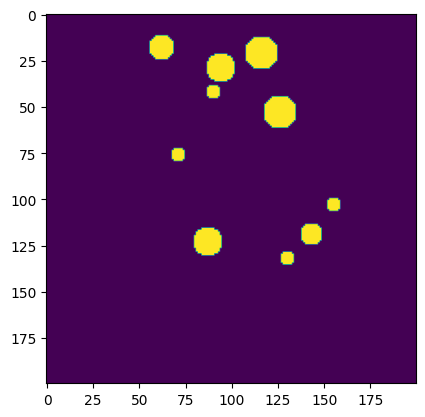

In [3]:
plt.imshow(particulas(np.zeros(shape=(200,200)), 10))

In [4]:
class DataImgs(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.nx = 200
        self.ny = 200
        self.data = np.array([particulas(np.zeros(shape=(self.nx,self.ny)), 10) for i in range(100)])

        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx].reshape(1,self.nx, self.ny)).float()

In [5]:
dataset = DataImgs()
dataloader = torch.utils.data.DataLoader(dataset, batch_size= 32, num_workers=3)

In [6]:

class Reshape(torch.nn.Module):
    def __init__(self, *args) -> None:
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Trim(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :100, :100]

class InitPool(torch.nn.Module):
    def __init__(self, *args) -> None:
        super().__init__()
        self.pool = torch.nn.AvgPool2d(kernel_size= (4,4))

    def forward(self, x):
        return self.pool(x)
    
class CNN_Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        leak = 2
        dr = 0.25
        self.encoder = torch.nn.Sequential(
                                torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),stride=(2,2), padding=1),
                                torch.nn.Dropout(dr),
                                torch.nn.ELU(leak),
                                torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=(2,2), padding=1),
                                torch.nn.Dropout(dr),
                                torch.nn.ELU(leak),
                                torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=(2,2), padding=1),
                                torch.nn.Dropout(dr),
                                torch.nn.ELU(leak),
                                torch.nn.Flatten(start_dim=1),
                                torch.nn.Linear(in_features=64*12*12,out_features=5),
                                # torch.nn.Tanh()
                                )

        self.decoder = torch.nn.Sequential(
                                torch.nn.Linear(in_features=5, out_features=64*12*12),
                                Reshape(-1,64,12,12),

                                torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1),
                                torch.nn.ELU(leak),
                                torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1),
                                torch.nn.ELU(leak),
                                torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1),
                                torch.nn.ELU(leak),
                                Trim(),
                                torch.nn.Sigmoid(),
                                )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
cnn_model = CNN_Autoencoder()
cnn_model.encoder(next(iter(dataloader)))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x40000 and 9216x5)

In [242]:
import os
import matplotlib.image as image
import sys
sys.path.append(os.path.join('..','..','..','Imgs_Flor'))
from process_imgs import manipulate_histogram, transform_one_bit, gaussian_border_detection, gaussian_denoising, read_frame

In [243]:
# Leemos los archivos
img_folder = os.path.join('..','..','..','Imgs_Flor','fase_dif_imagenes')
frames = []
for i in range(61, 226):
    frame = read_frame(img_folder, i)
    # we expand the image histogram to increase contrast
    frame = manipulate_histogram(frame)
    # we downsample the image to one bit for further clustering
    frame = transform_one_bit(frame, threshold=0.6)
    frames.append(frame)
print(len(frames))

165


In [244]:
# pool layer to resample 
pool = torch.nn.AvgPool2d(kernel_size=(11,8))
rng = np.random.default_rng()

In [255]:
transformed = []
for f in frames:
    resampled = pool(torch.FloatTensor(f).view(1,572,768)).squeeze(0).numpy()
    recoso = np.maximum(0,gaussian_border_detection(resampled, kernel_size = (7,7)))
    transformed.append(recoso)

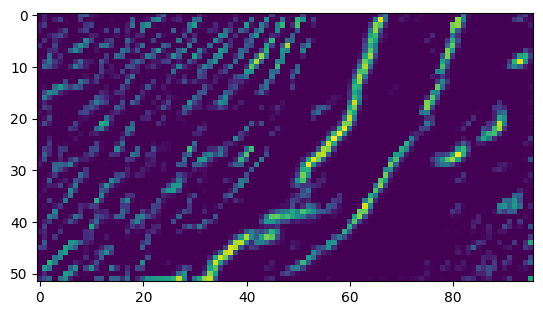

In [269]:
plt.imshow(transformed[40])

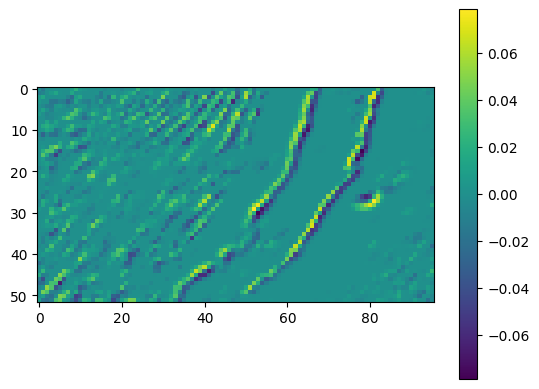

In [270]:
plt.imshow(transformed[40]-transformed[39])
plt.colorbar()

In [218]:
class CNNA(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # n, 52, 96
        self.conv = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), stride=1, padding=1)
        self.act = torch.nn.ELU(2)
        self.drop = torch.nn.Dropout(0.25)
        self.lin = torch.nn.Linear(16*52*96,10)

        self.decoder = torch.nn.Sequential(
                                    torch.nn.Linear(10, 16*52*96),
                                    Reshape(-1,16,26,48),
                                    torch.nn.ConvTranspose2d(in_channels = 16, 
                                                             out_channels = 1, 
                                                             kernel_size=(3,3), 
                                                             stride=2, 
                                                             padding=1,
                                                             output_padding=1)
            
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.lin(x.flatten(1))
        x = self.decoder(x)
        return x


In [258]:
model = CNNA()
model(torch.FloatTensor(transformed[0]).view(1,1,52,96))

tensor([[[[ 0.3161,  0.0308,  0.2083,  ...,  0.1967,  0.2372,  0.2519],
          [ 0.3713, -0.2047,  0.2519,  ...,  0.6530,  0.0226,  0.3272],
          [ 0.3241, -0.4083, -0.0351,  ...,  0.5807,  0.2361,  0.1013],
          ...,
          [ 0.2379,  0.0957,  0.2815,  ...,  0.2880, -0.2459,  0.4175],
          [ 0.2533,  0.3476,  0.3056,  ...,  0.2238,  0.1196,  0.0799],
          [ 0.4612,  0.4555,  0.0372,  ...,  0.3436,  0.2931,  0.4898]]],


        [[[ 0.1790,  0.0817,  0.1830,  ...,  0.1092,  0.1559,  0.3202],
          [ 0.2235,  0.4857,  0.1571,  ...,  0.4887,  0.0127, -0.0729],
          [ 0.2429,  0.2746,  0.2863,  ...,  0.2235,  0.2732,  0.1967],
          ...,
          [-0.1485, -0.0482,  0.5686,  ...,  0.1542,  0.0171,  0.3658],
          [ 0.0916,  0.3362,  0.2187,  ...,  0.0358, -0.0572,  0.3198],
          [ 0.1968,  0.1832,  0.2432,  ...,  0.3283,  0.4404,  0.0970]]],


        [[[ 0.2240,  0.0700,  0.1474,  ...,  0.4626,  0.3244,  0.0449],
          [ 0.1498,  0.133

In [259]:
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterio = torch.nn.MSELoss()
hist = []

In [262]:
for i in range(len(transformed)):
    x = torch.FloatTensor(transformed[i]).view(1,1,52,96)
    y_pred = model(x)
    loss = criterio(y_pred,x)
    opt.zero_grad()
    loss.backward()
    opt.step()
    hist.append(loss.item())
    print(hist[-1])

0.028971852734684944
0.045850347727537155
0.027135634794831276
0.024489836767315865
0.02122822031378746
0.02580837719142437
0.019358396530151367
0.01998627558350563
0.02778744138777256
0.02933737263083458
0.021225279197096825
0.021673070266842842
0.02438417449593544
0.029857806861400604
0.031042780727148056
0.02377139776945114
0.02078266069293022
0.01824459247291088
0.018122749403119087
0.02327372133731842
0.019420498982071877
0.018902039155364037
0.018694542348384857
0.0298596378415823
0.01930299587547779
0.018436038866639137
0.02188248001039028
0.02663610503077507
0.018824368715286255
0.015994185581803322
0.026740336790680885
0.023868221789598465
0.016988495364785194
0.021072866395115852
0.02243851311504841
0.015907984226942062
0.018636425957083702
0.027301238849759102
0.016752906143665314
0.026656346395611763
0.037731874734163284
0.017856916412711143
0.01664401777088642
0.01887671835720539
0.01865723729133606
0.01606653816998005
0.019002651795744896
0.025287184864282608
0.0278454720

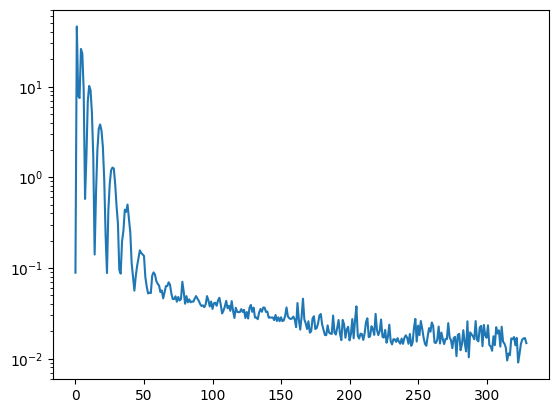

In [263]:
plt.semilogy(hist)

In [266]:
idx = 60
pp = model.conv(torch.FloatTensor(transformed[idx]).view(1,1,52,96)).detach().numpy()
pp.shape

(1, 16, 52, 96)

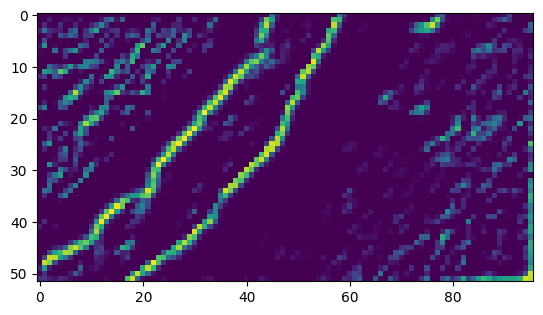

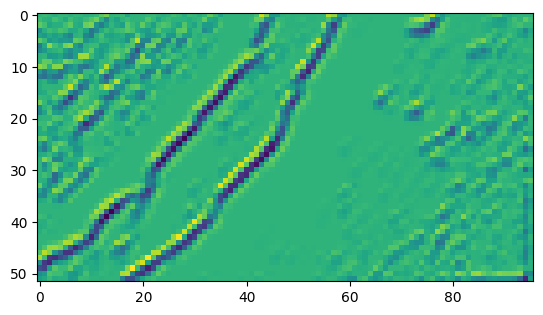

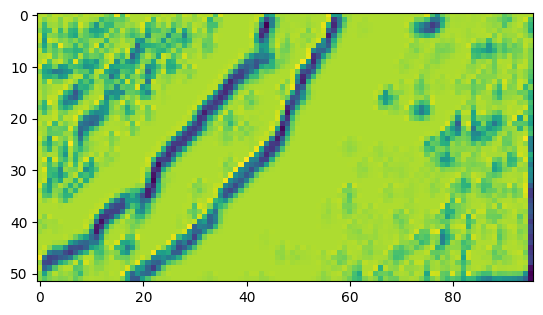

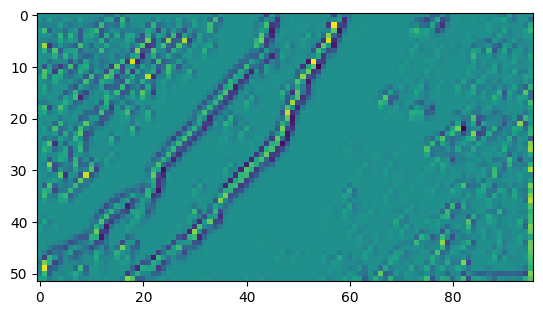

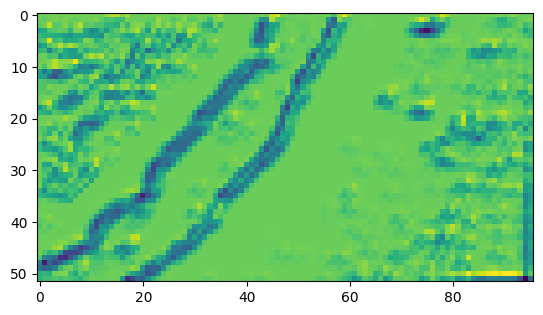

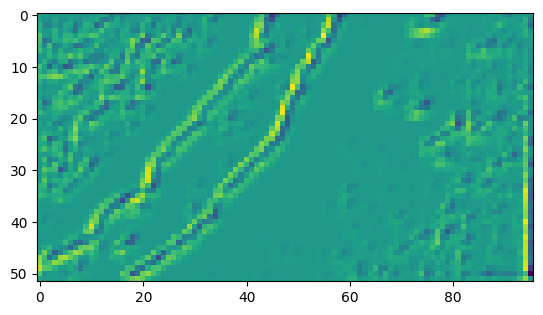

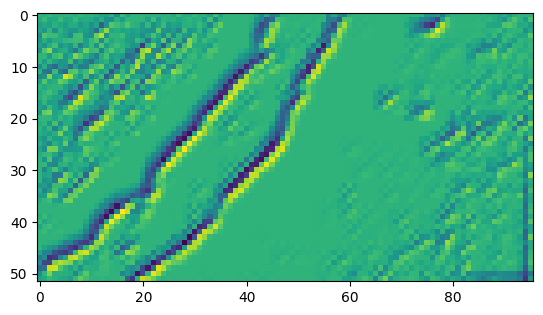

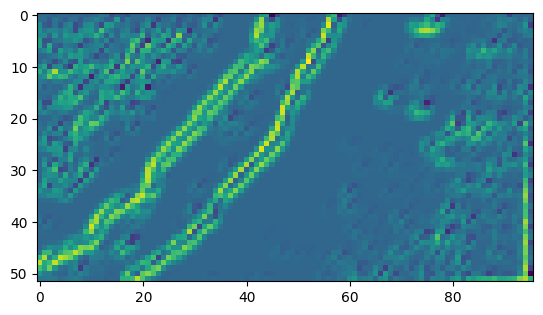

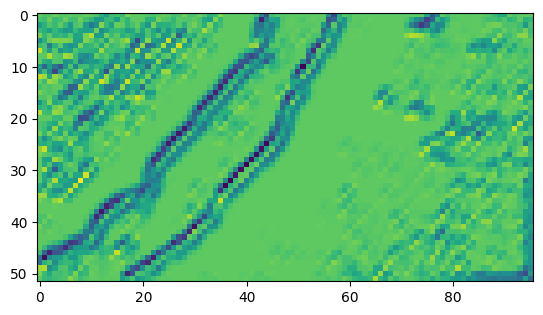

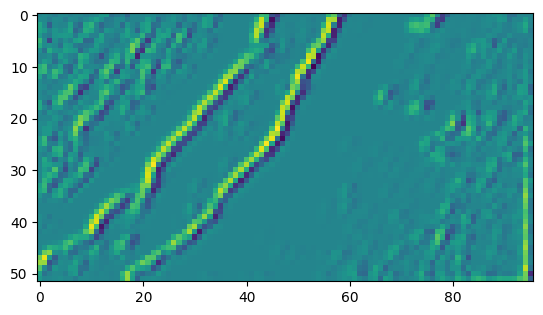

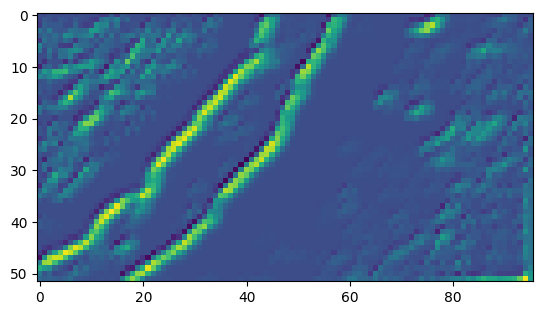

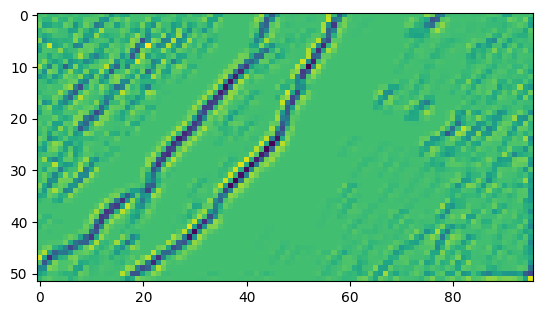

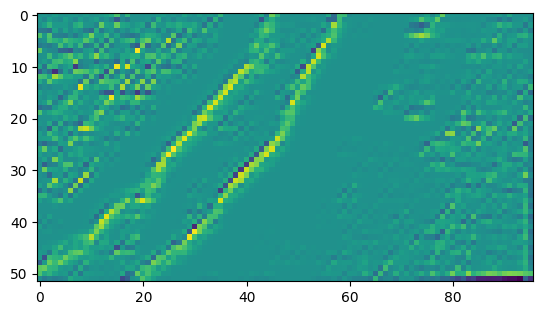

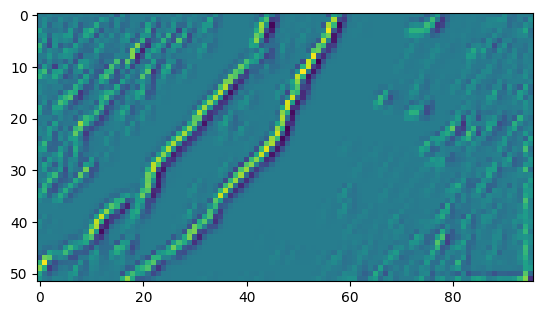

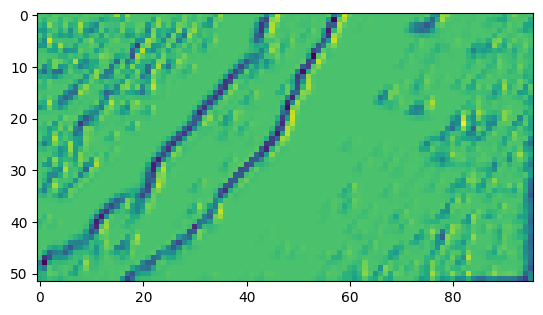

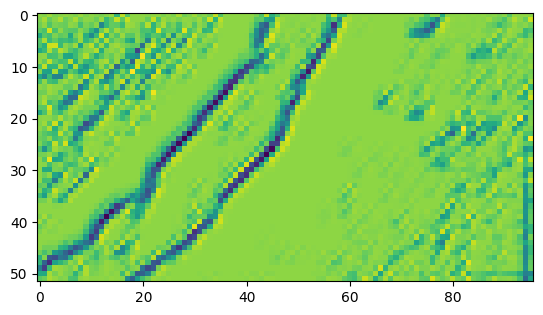

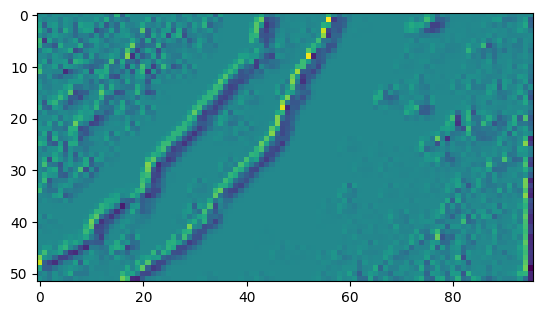

In [267]:
plt.imshow(transformed[idx])
plt.show()
for i in range(16):
    plt.imshow(pp[0,i,:,:])
    plt.show()

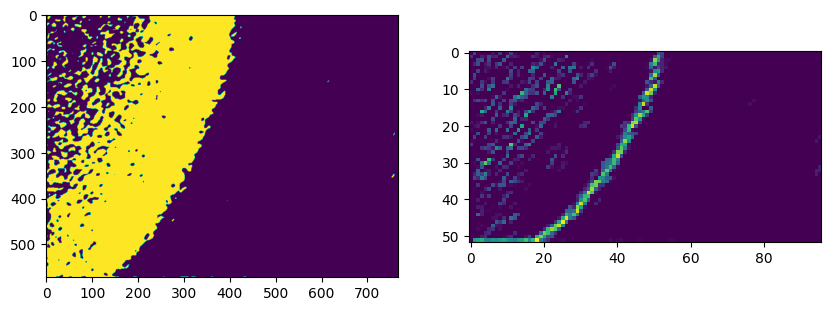

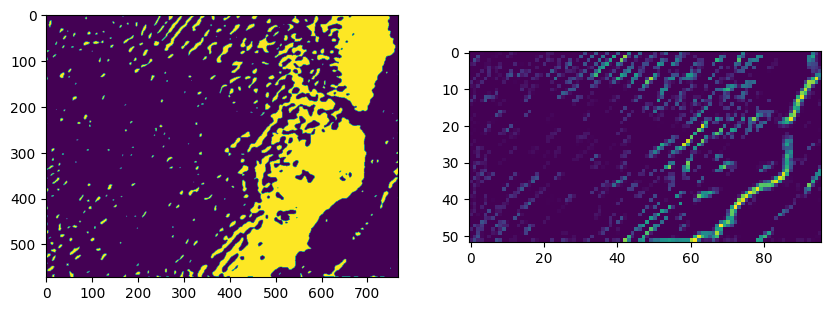

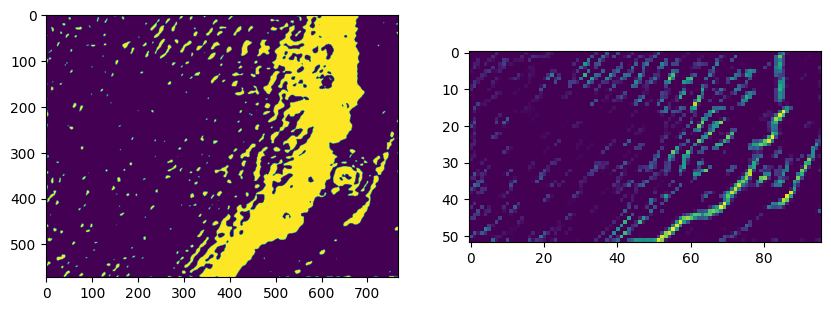

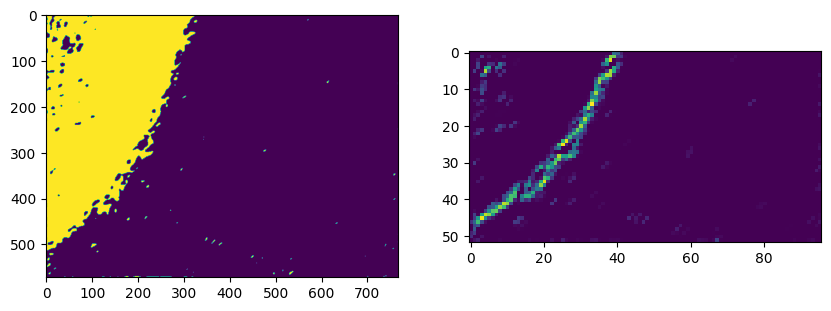

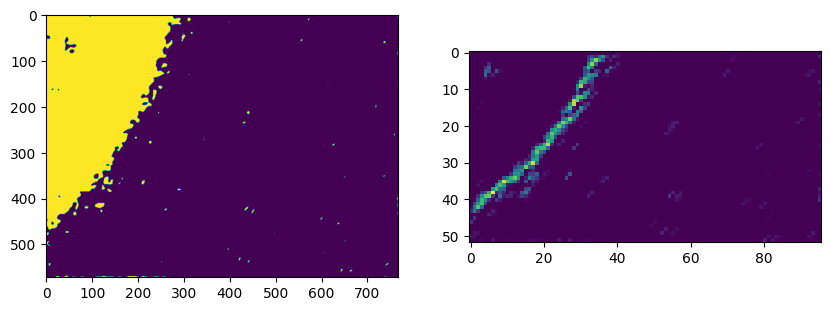

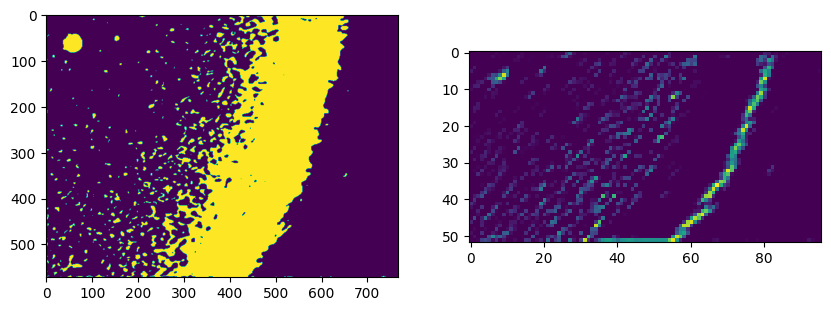

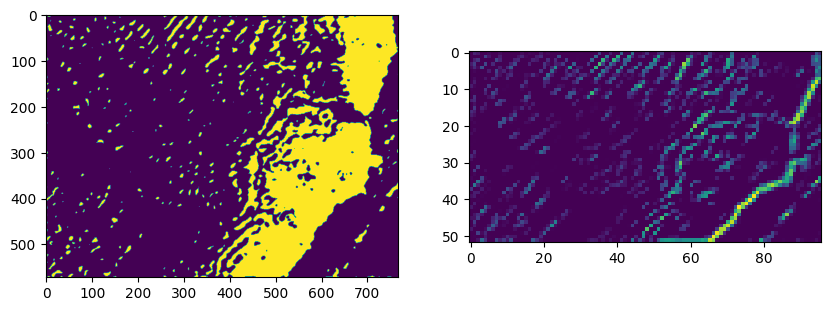

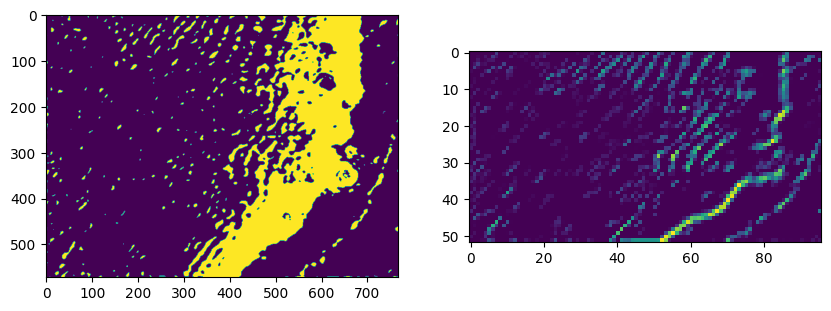

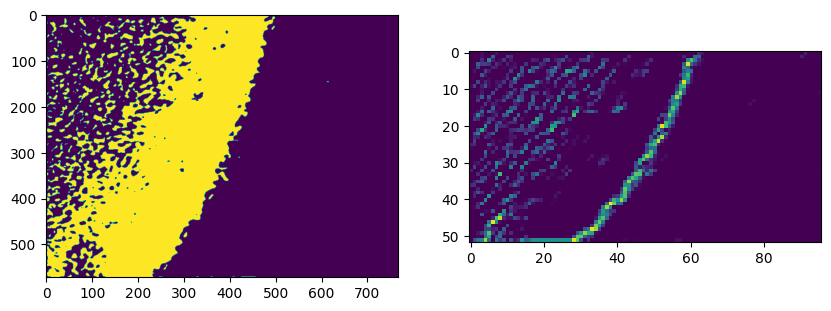

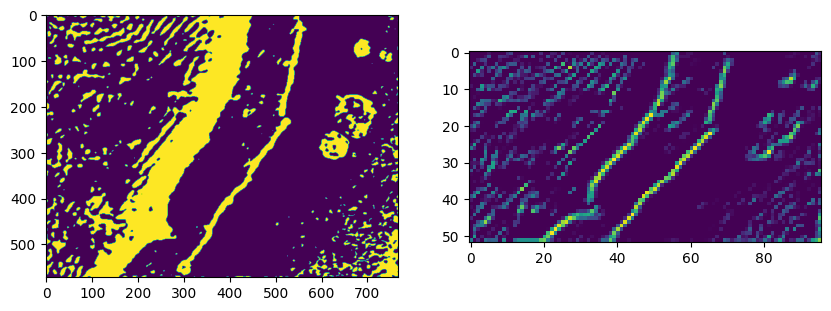

(572, 768)

In [138]:
for i in range(10):
    idx = rng.integers(165)
    resampled = pool(torch.FloatTensor(frames[idx]).view(1,572,768)).squeeze(0).numpy()
    # recoso = transform_one_bit(gaussian_border_detection(resampled, kernel_size = (3,3)), threshold=0.15)
    recoso = np.maximum(0,gaussian_border_detection(resampled, kernel_size = (3,3)))
    fig, axes = plt.subplots(1,2, figsize = (10,5))
    axes[1].imshow(recoso)
    axes[0].imshow(frames[idx])
    plt.show()
frames[0].shape # veamos los tamanios

In [115]:
from sklearn.cluster import HDBSCAN
x,y = np.where(recoso.T  > 0.05)
print(x.shape)
X = np.vstack([x, y]).T
clusterizador = HDBSCAN()
clusterizador.fit_predict(X)

(387,)


array([ 3,  3,  3, -1,  3,  3,  3,  3,  3, -1,  3, -1, -1,  3,  3,  3,  4,
       -1, -1,  4,  4, -1,  4,  4,  4, -1, -1,  4,  4, -1,  1,  1,  1,  1,
        1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
        1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,
       -1,  1,  1, -1, -1,  1,  1, -1,  1,  2, -1,  1,  1,  2,  2,  6,  6,
        1,  2, -1,  6,  6,  6,  1,  1,  6,  6,  6,  1,  1, -1,  6,  6,  6,
        1,  1, -1,  6,  6,  1,  1,  6,  6,  1,  1,  2,  2,  6,  6,  1,  1,
        1,  6,  6,  1,  1,  2, -1,  6,  6,  1,  1,  1, -1, -1,  6,  6,  1,
        1,  1,  1,  1,  1,  2,  6,  6,  1,  1,  1,  1,  6,  6,  1,  6,  6,
        1,  6,  6,  1,  1,  1, -1,  6,  6,  1, -1,  6,  6,  1,  6,  6, -1,
        1,  1,  1,  1,  6,  6, -1,  1,  1,  6,  6,  8,  1,  1,  1, -1,  6,
        6,  8,  8,  1,  1,  1,  6,  6,  6,  6,  6,  8,  8,  1,  1,  1,  1,
        1,  6,  6,  6,  6,  6,  6,  8,  8,  1,  1,  1,  1,  1,  6,  6,  6,
        8,  8,  1,  1,  6

In [95]:
clusterizador.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

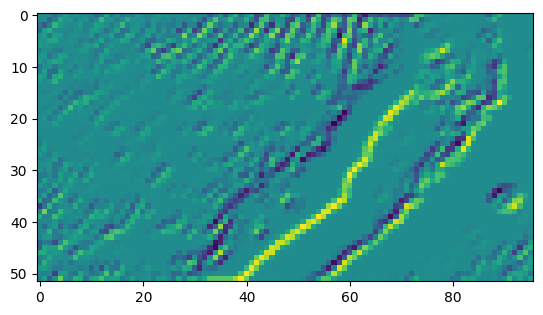

In [76]:
plt.imshow(gaussian_border_detection(resampled, kernel_size = (3,3)))